This demo shows how to use the `nnbits` repository by 

1. generating the avalanche dataset for round 7 of Speck 32/64
2. exploring the computational resources
3. running an ensemble neural network analysis

It reproduces the corresponding results from the manuscript.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Install-Requirements" data-toc-modified-id="Install-Requirements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Install Requirements</a></span></li><li><span><a href="#Choose-a-round-to-analyze" data-toc-modified-id="Choose-a-round-to-analyze-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Choose a round to analyze</a></span></li><li><span><a href="#Generate-avalanche-data" data-toc-modified-id="Generate-avalanche-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate avalanche data</a></span></li><li><span><a href="#Have-a-look-at-the-available-resources" data-toc-modified-id="Have-a-look-at-the-available-resources-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Have a look at the available resources</a></span></li><li><span><a href="#Run-nnbits-neural-network-analysis" data-toc-modified-id="Run-nnbits-neural-network-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run <code>nnbits</code> neural network analysis</a></span></li><li><span><a href="#Analyze-the-results" data-toc-modified-id="Analyze-the-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analyze the results</a></span></li></ul></div>

# How to use this demo?
Please execute the following cells by pressing 

`Shift + Enter`.

<font color='blue'>**Important**</font> If you are executing the Notebook on <font color='blue'>Google Colaboratory, please enable GPU support by clicking on `Runtime > Change Runtime Type > Hardware accelerator "GPU" > Save`</font>:

# Install Requirements 

Clone the GitHub repository:

In [ ]:
!git clone https://github.com/Crypto-TII/nnbits

Change directory into the cloned repository:

In [ ]:
%cd nnbits/

The following modules are required: 

In [ ]:
%cat requirements.txt

Install the requirements by running the following cell. 

In [ ]:
!pip install -r requirements.txt

# Choose a round to analyze 

In [3]:
# Here we will analyze round 7 of Speck 32/64.
# The corresponding round-id is round 6 (we start counting the round-id from zero):
ROUND_IDs = [6]

# Generate avalanche data 

Create a folder for the data

In [15]:
!mkdir 'speck_32_64'

Generate `number_of_samples = 300_000` avalanche units (this takes about one minute in Google Colab):

In [17]:
#### CONFIGURATION ######

number_of_samples = 300_000

#########################

from avalanche_data_generator.speck_32_64 import speck_k64_p32_o32_r22 as data_generator
import numpy as np

dataset = data_generator.generate_avalanche_dataset(int(number_of_samples))

for r in ROUND_IDs:
    np.save(f"speck_32_64/round{r}_sequences300k.npy", dataset[r])

# Have a look at the available resources 

The Nvidia A100-DGX server provides 

* `4 A100-SXM GPUs, each with 40'536 MiB memory (and in addition a graphical GPU)` 
* `128 CPU cores`

In comparison, the free Google Colaboratory provides

* `1 Tesla T4 GPU with 15'109 MiB memory`
* `2 CPU cores`

The available resources can be explored by using for example the `ray.available_resources()` or `nvidia-smi`:

In [1]:
import ray
ray.init()
ray.available_resources()

{'node:172.31.102.84': 1.0,
 'object_store_memory': 138092019302.0,
 'memory': 312214711706.0,
 'CPU': 128.0,
 'GPU': 5.0}

In [2]:
!nvidia-smi

Sat Jun  4 10:54:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   36C    P0    51W / 275W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off |                    0 |
| N/A   

# Run `nnbits` neural network analysis 

If you are executing the Notebook on <font color='blue'>Google Colaboratory, please ensure that the following four lines are identical in the cell below</font>:

```python
...
# hardware settings
'N_GPUS': 1, 
'N_ACTORS_PER_GPU': 2,
'GPU_PER_ACTOR': 0.5,
'CPU_PER_ACTOR': 0.5,
...
```

If you work on a 4-GPU server with 40 GB memory per GPU, the following settings would be appropriate 
```python
...
# hardware settings
'N_GPUS': 4,
'N_ACTORS_PER_GPU': 6,
'GPU_PER_ACTOR': 0.15,
'CPU_PER_ACTOR': 5, 
...
```

In [4]:
import toml
from nnbits.filemanager import FileManager

for r in ROUND_IDs:
    
    # choose where to save the data
    savepath = f'demo_speck32_roundid{r}'
    !rm -r '{savepath}'
    !mkdir '{savepath}'
    
    # choose the settings
    config = {'DATAPATH': f'speck_32_64/round{r}_sequences300k.npy',
               # ensemble settings
                 'NEURAL_NETWORK_MODEL': 'gohr_generalized', 
                 'NEURAL_NETWORKS': 100, 
                 'SELECT_BITS_STRATEGY': 'random', 
                 'INPUT_DATA_OP': 'zero', 
                 'N_RANDOM_BITS': 63,
               # hardware settings
                'N_GPUS': 1, 
                'N_ACTORS_PER_GPU': 2,
                'GPU_PER_ACTOR': 0.5,
                'CPU_PER_ACTOR': 0.5,
               # training settings
                 'N_EPOCHS': 5,
                 'N_TRAIN': 145_000,
                 'N_VAL': 145_000,
                 'N_TEST': 0,
                 'BATCHSIZE': 5000}
    
    # save the configuration file
    F = FileManager(savepath)

    with open(F.filename_config(), 'w') as configfile:
        toml.dump(config, configfile)
        
    #============ run the analysis ============
    !python -m nnbits.run --savepath '{savepath}'

2022-09-21_16h49m41s 	 started to load data from harddisk...
2022-09-21_16h49m41s 	 finished.
|                             | value                                |
|:----------------------------|:-------------------------------------|
| DATAPATH                    | speck_32_64/round6_sequences300k.npy |
| NEURAL_NETWORK_MODEL        | gohr_generalized                     |
| NEURAL_NETWORKS             | 100                                  |
| SELECT_BITS_STRATEGY        | random                               |
| INPUT_DATA_OP               | zero                                 |
| N_RANDOM_BITS               | 63                                   |
| N_GPUS                      | 1                                    |
| N_ACTORS_PER_GPU            | 2                                    |
| GPU_PER_ACTOR               | 0.5                                  |
| CPU_PER_ACTOR               | 0.5                                  |
| N_EPOCHS                    | 5                     

# Analyze the results 

In [29]:
import numpy as np

Each neural network has been tested on the test-data and the results are saved in the `test_accuracies` folder:

In [30]:
!ls 'demo_speck32_roundid6'

bit_selections	h5    run_log.pkl      test_accuracies_bit_by_bit
config.cfg	hist  test_accuracies


In [31]:
!ls 'demo_speck32_roundid6/test_accuracies'

0.npy	11.npy	1.npy  3.npy  5.npy  7.npy  9.npy
10.npy	12.npy	2.npy  4.npy  6.npy  8.npy


In [32]:
# the file-manager is a simple module which knows under which path to search for e.g. the test_accuracies:
from nnbits.filemanager import FileManager
F = FileManager('demo_speck32_roundid6') 

In [33]:
# given a file-manager, the get_X function loads all the test_accuracies from above into a single array:
from nnbits.bitanalysis import get_X
X = get_X(F)
# X contains one row for each of the `N` neural network and one column for each of the `n` bits:
X.shape

(100, 1024)

In [36]:
# the bit accuracies are calculated by taking the mean over all neural networks which predict the particular bit 
# (axis=0):
# (the following three lines catch a runtime warning if a mean-calculation is empty. This happens if not all bits have been analyzed yet.)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    bit_accuracies = np.nanmean(X, axis=0)

In [37]:
import pandas as pd
df = pd.DataFrame({'bit': np.arange(1024), 
                   'mean accuracy': bit_accuracies})

df.sort_values('mean accuracy', ascending=False)

,bit,mean accuracy
732,732,0.509393
436,436,0.503614
482,482,0.503428
62,62,0.503400
680,680,0.503234
...,...,...
1016,1016,NaN
1017,1017,NaN
1018,1018,NaN
1020,1020,NaN


Text(0, 0.5, 'validation accuracy')

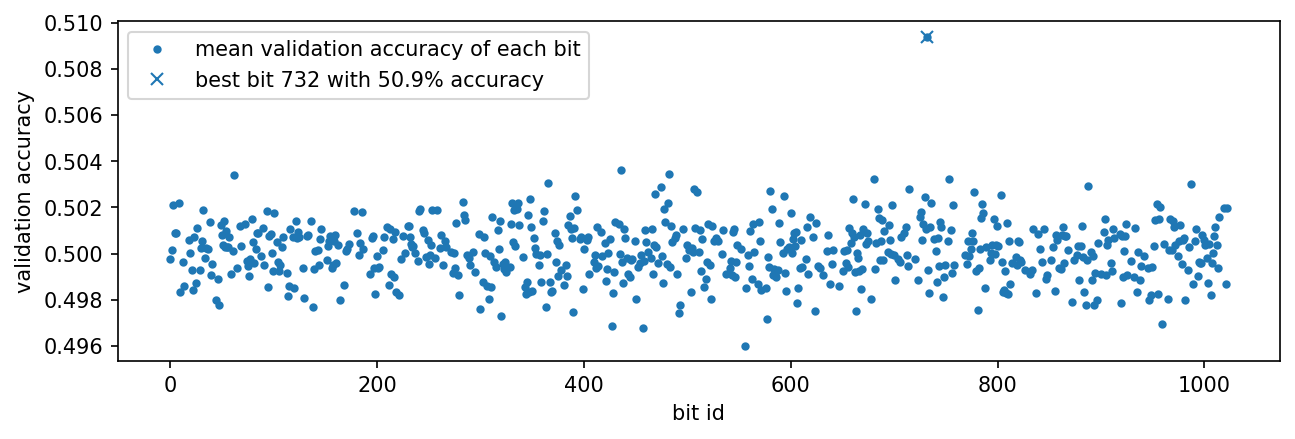

In [60]:
import matplotlib.pyplot as plt

# here we visualize the obtained `bit_accuracies`:
plt.figure(figsize=(10, 3), dpi=150)
plt.plot(bit_accuracies, 'o', markersize=3, linestyle = 'None', label="mean validation accuracy of each bit")
# find bit with maximum accuracy
dfm = df[df['mean accuracy'] == max(df['mean accuracy'])]
plt.plot(dfm['bit'], dfm['mean accuracy'], marker='x', c='C0', linestyle = 'None', label=f"best bit {int(dfm['bit'])} with {float(dfm['mean accuracy'])*100:.1f}% accuracy")

plt.legend(loc='upper left')
plt.xlabel('bit id')
plt.ylabel('validation accuracy')